In [1]:
import os
import shutil
import copy
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import torch
from torchvision import datasets , transforms, models
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [2]:
src_path = "/kaggle/input/animals10/raw-img"
path = "/kaggle/working/raw-img"

shutil.copytree(src_path, path, dirs_exist_ok=True)

'/kaggle/working/raw-img'

In [3]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}
classes = os.listdir(path)

In [4]:
for category in classes:
    category_path = os.path.join(path, category)
    if os.path.isdir(category_path):
        eng_name = translate.get(category, category)
        eng_path = os.path.join(path, eng_name)
        if eng_name != category:
            os.rename(category_path, eng_path)

In [5]:
dataset = datasets.ImageFolder(root=path)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 26179
    Root location: /kaggle/working/raw-img


In [6]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
test_size = int(0.2 * dataset_size)
val_size = dataset_size - train_size - test_size

In [7]:
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

In [8]:
def get_transform(aug_type="light"):
    if aug_type == "light":
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149)),
        ])
    elif aug_type == "heavy":
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(30),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149)),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149)),
        ])

In [9]:
def update_dataloaders(train_transform, val_transform):
    train_dataset_aug = Subset(datasets.ImageFolder(root=path, transform=train_transform), train_dataset.indices)
    val_dataset_aug = Subset(datasets.ImageFolder(root=path, transform=val_transform), val_dataset.indices)

    train_dl = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dl = DataLoader(val_dataset_aug, batch_size=batch_size*2, shuffle=False, num_workers=4, pin_memory=True)

    return train_dl, val_dl

In [59]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [60]:
model.fc = nn.Linear(model.fc.in_features, 10)

In [61]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [62]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [63]:
layers = ['layer4', 'layer3', 'layer2', 'layer1']

In [74]:
def train_model(model, train_dl, val_dl, device, optimizer, scheduler, epochs=10):
    import copy
    import torch.nn as nn

    loss_function = nn.CrossEntropyLoss()
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0


    for epoch in range(epochs):
        # if epoch < len(layers_to_unfreeze):
        #     layer_name = layers_to_unfreeze[epoch]
        #     print(f"\nunfreezing {layer_name}")
        #     for param in getattr(model, layer_name).parameters():
        #         param.requires_grad = True
        #     optimizer.add_param_group({
        #         'params': filter(lambda p: p.requires_grad, getattr(model, layer_name).parameters())
        #     })

        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dl)
        epoch_acc = running_corrects / len(train_dl.dataset)
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_dl:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = loss_function(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_loss += loss.item()
                val_corrects += torch.sum(val_preds == val_labels.data).item()

        val_epoch_loss = val_loss / len(val_dl)
        val_epoch_acc = val_corrects / len(val_dl.dataset)
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")
        
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    model.load_state_dict(best_model_wts)
    return model, history


In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model.to(device)

In [66]:
batch_size = 128

In [67]:
test_dataset = Subset(datasets.ImageFolder(root=path, transform=get_transform()), test_dataset.indices)
test_dl = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

In [68]:
def evaluate_model(model, test_dl, device):
    model.eval()
    all_preds, all_labels = [], []
    class_names = dataset.classes

    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [71]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Val Loss')
    ax[0].set_title('Loss per Epoch')
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='Train Acc')
    ax[1].plot(history['val_acc'], label='Val Acc')
    ax[1].set_title('Accuracy per Epoch')
    ax[1].legend()


    plt.show()

In [69]:
print("\nStage 1: Light aug")
train_dl_stage1, val_dl_stage1 = update_dataloaders(get_transform("light"), get_transform("light"))
model1, history1 = train_model(model1, train_dl_stage1, val_dl_stage1, device, optimizer,scheduler, layers, epochs=7)


Stage 1: Light aug

unfreezing layer4
Epoch 1/7 | Train Loss: 0.2302 | Train Acc: 0.9417 | Val Loss: 0.1173 | Val Acc: 0.9656

unfreezing layer3
Epoch 2/7 | Train Loss: 0.0648 | Train Acc: 0.9812 | Val Loss: 0.1215 | Val Acc: 0.9702

unfreezing layer2
Epoch 3/7 | Train Loss: 0.0331 | Train Acc: 0.9907 | Val Loss: 0.1066 | Val Acc: 0.9679

unfreezing layer1
Epoch 4/7 | Train Loss: 0.0299 | Train Acc: 0.9911 | Val Loss: 0.1280 | Val Acc: 0.9664
Epoch 5/7 | Train Loss: 0.0191 | Train Acc: 0.9950 | Val Loss: 0.1173 | Val Acc: 0.9683
Epoch 6/7 | Train Loss: 0.0098 | Train Acc: 0.9974 | Val Loss: 0.0956 | Val Acc: 0.9748
Epoch 7/7 | Train Loss: 0.0044 | Train Acc: 0.9991 | Val Loss: 0.0926 | Val Acc: 0.9763


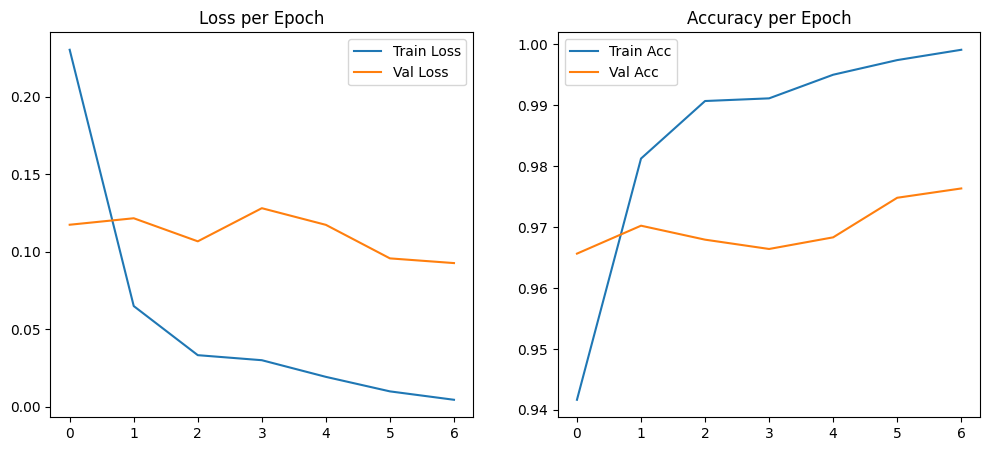

In [72]:
plot_training_history(history1)

Test Accuracy: 0.9784
F1 Score (weighted): 0.9784
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.99      0.98      0.98       417
         cat       0.97      0.96      0.97       354
     chicken       0.99      0.97      0.98       597
         cow       0.97      0.96      0.97       363
         dog       0.97      0.98      0.98       977
    elephant       1.00      0.98      0.99       266
       horse       0.97      0.99      0.98       552
       sheep       0.95      0.95      0.95       375
      spider       0.98      0.99      0.99       933
    squirrel       0.99      0.99      0.99       401

    accuracy                           0.98      5235
   macro avg       0.98      0.98      0.98      5235
weighted avg       0.98      0.98      0.98      5235



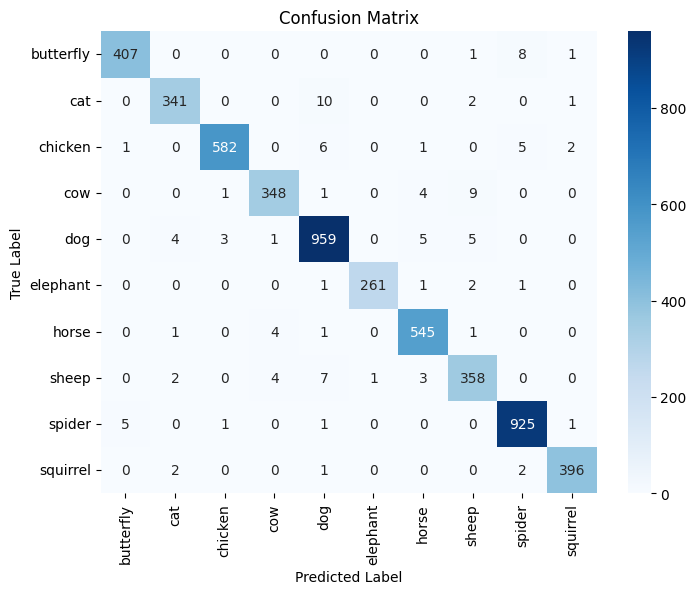

In [70]:
evaluate_model(model1, test_dl, device)

**Cпроби з чергуванням аугментацій.** 

5 - 7 епох - легка аугментація.

5 - 10 епох - складна аугментація.

Результат дуже слабо покращився (а іноді чомусь погіршувався - приклад далі), тому вирішено не проводити додаткове тренування на даних із сильною аугментацією.

In [75]:
print("\nStage 2: Heavy aug")
train_dl_stage2, val_dl_stage2 = update_dataloaders(get_transform("heavy"), get_transform("heavy"))
model3, history2 = train_model(model1, train_dl_stage2, val_dl_stage2, device, optimizer,scheduler, epochs=5)


Stage 2: Heavy aug
Epoch 1/5 | Train Loss: 0.1180 | Train Acc: 0.9632 | Val Loss: 0.1615 | Val Acc: 0.9580
Epoch 2/5 | Train Loss: 0.0701 | Train Acc: 0.9772 | Val Loss: 0.1621 | Val Acc: 0.9588
Epoch 3/5 | Train Loss: 0.0577 | Train Acc: 0.9824 | Val Loss: 0.1603 | Val Acc: 0.9599
Epoch 4/5 | Train Loss: 0.0489 | Train Acc: 0.9841 | Val Loss: 0.1534 | Val Acc: 0.9607
Epoch 5/5 | Train Loss: 0.0481 | Train Acc: 0.9857 | Val Loss: 0.1395 | Val Acc: 0.9641


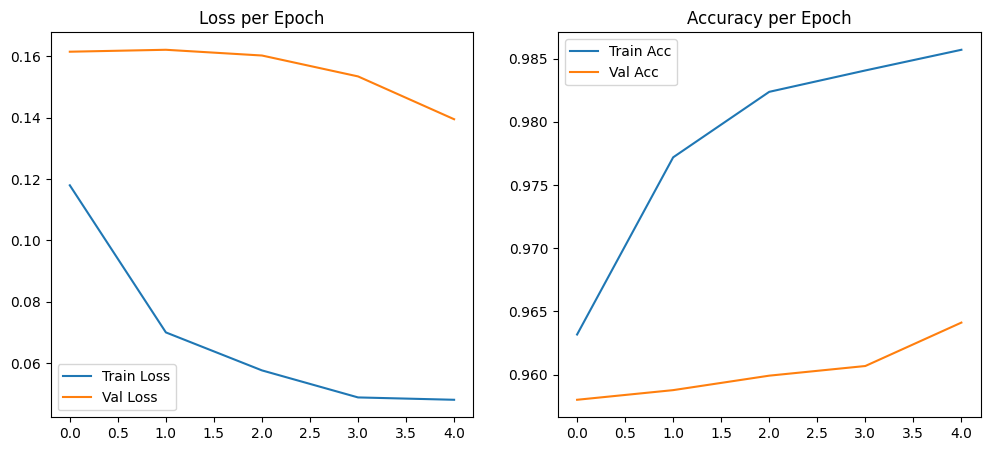

In [77]:
plot_training_history(history2)

Test Accuracy: 0.9778
F1 Score (weighted): 0.9778
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.99      0.99      0.99       417
         cat       0.99      0.97      0.98       354
     chicken       0.98      0.98      0.98       597
         cow       0.98      0.93      0.96       363
         dog       0.96      0.99      0.97       977
    elephant       0.99      0.98      0.98       266
       horse       0.97      0.98      0.98       552
       sheep       0.95      0.95      0.95       375
      spider       0.99      0.99      0.99       933
    squirrel       0.99      0.99      0.99       401

    accuracy                           0.98      5235
   macro avg       0.98      0.97      0.98      5235
weighted avg       0.98      0.98      0.98      5235



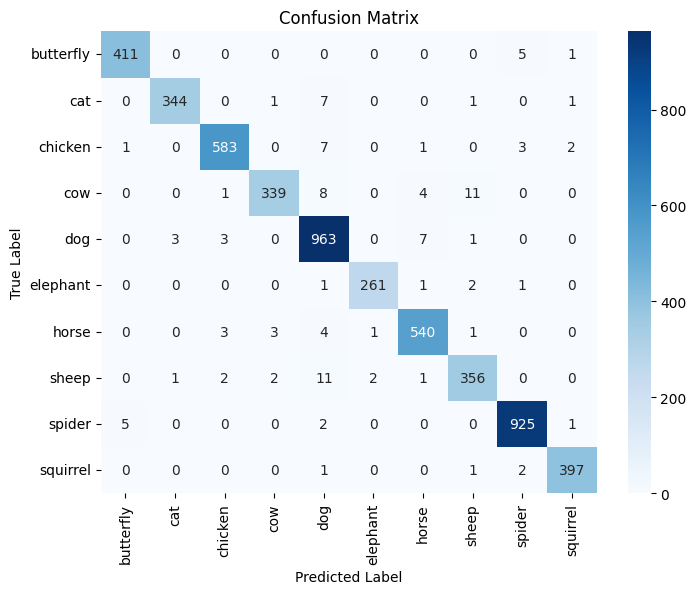

In [76]:
evaluate_model(model3, test_dl, device)

In [78]:
def show_misclassified_images(model, dataloader, class_names, device, max_images=10):
    model.eval()
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    misclassified_images.append(img.cpu())
                    misclassified_preds.append(pred.cpu())
                    misclassified_labels.append(label.cpu())

                if len(misclassified_images) >= max_images:
                    break
            if len(misclassified_images) >= max_images:
                break

    plt.figure(figsize=(15, 5))
    for i in range(len(misclassified_images)):
        plt.subplot(1, len(misclassified_images), i + 1)
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(f"True: {class_names[misclassified_labels[i]]}\nPred: {class_names[misclassified_preds[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

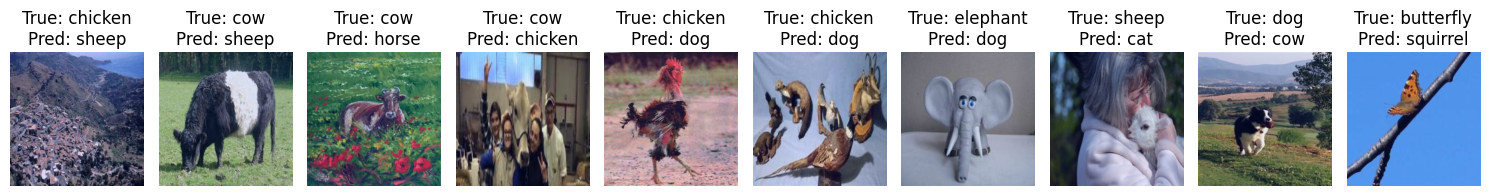

In [80]:
show_misclassified_images(model1, val_dl_stage1, dataset.classes, device)

**Висновок:**
Було використано модель resnet, спочатку заморожено та поступово розморожено шари. Тренування відбувалося лише 7 епох (експериментально визначено як оптимальний варіант).

Test Accuracy: 0.9778

F1 Score (weighted): 0.9778

In [83]:
new_path = '/kaggle/working/resnet-animal10.pth'
torch.save(model1.state_dict(), new_path)